<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S15/Office_Dataset_UNet_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hardware Properties**

In [ ]:
!pip install --upgrade torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.7.0+cu101)


In [1]:
import torch
from IPython.display import Image, clear_output 
from time import time
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


**Mount the Drive**

In [2]:

from google.colab import drive
drive.mount('/content/drive')
# how_long(start_time)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import zipfile# Unzip the File

def zip_data(zipfile, path_to_zipfile, directory_to_extract):
  print('Outside loop')
  with zipfile.ZipFile(path_to_zipfile, 'r') as zip:
    print('Extracting ZIP')
    zip.extractall(directory_to_extract)
  print("Zipfile extracted to", directory_to_extract)


In [4]:

path = '/content/drive/My Drive/ZipFiles/data_TenK101.zip'
save = '/content/drive/My Drive/ZipExtract'
zip_data(zipfile,path, save)

Outside loop
Extracting ZIP
Zipfile extracted to /content/drive/My Drive/ZipExtract


In [ ]:
# zip = zipfile.ZipFile('/content/drive/My Drive/ZipFiles/data_TenK101.zip')
# zip.extractall(save)

In [4]:
import os
os.listdir('/content/drive/My Drive/ZipExtract')


['batch0204.zip',
 'NewTest',
 'BG DATASET.zip',
 'BG DATASET',
 'FG DATASET',
 'data_TenK',
 'data_TenK101']

**Set the path for all 4 type of Images**

In [3]:
import os
zip_path = "/content/drive/My Drive/ZipExtract/data_TenK101"
subd = os.listdir(zip_path) #Returns sub-directories

bg_path = '/content/drive/My Drive/ZipExtract/data_TenK101/BG'

bgfg_path = '/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG' 

bgfg_mask_path = '/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG Masks'

depthmap_path = '/content/drive/My Drive/ZipExtract/data_TenK101/DepthMaps'

  

In [7]:
from PIL import Image
import cv2
img = cv2.imread('/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG Masks/bg_001_fg_001_001.jpeg')
img.shape

(224, 224, 3)

In [5]:
bgfg = sorted([ file for file in os.listdir(bgfg_path)])
bgfg[:4]

['bg_001_fg_001_001.jpeg',
 'bg_001_fg_001_002.jpeg',
 'bg_001_fg_001_003.jpeg',
 'bg_001_fg_001_004.jpeg']

In [12]:
mask = sorted([ file for file in os.listdir(bgfg_mask_path)])
mask[:4]


['bg_001_fg_001_001.jpeg',
 'bg_001_fg_001_002.jpeg',
 'bg_001_fg_001_003.jpeg',
 'bg_001_fg_001_004.jpeg']

**Image Segmentation File**

In [6]:
# start_time = t.time()
# Now the first task is to clip input and output
# This is done since BG has only 100 images while BG_FG has around 400K, but for this I'm using 10K
# Now to do this I've used this snippet below, which will clip in the inputs with it's corresponding ground truth
masks = [mask for mask in os.listdir(bgfg_mask_path)] # Mask Files

bg_idx = [int(m.split('_')[1]) for m in masks] # Background file index
set(bg_idx)
# # for i in set(bg_idx):
#   print(bg_idx.count(i))
bgfiles = [os.path.join(bg_path, bg) for bg in os.listdir(bg_path)] # all 100 BG Files
rev_bg_files = [os.path.join(bgfg_mask_path, bgfiles[idx-1]) for idx in bg_idx ] # BG Files of Proper index
rev_bg_files[::-1]
# how_long(start_time)

['/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK101/BG/bg001.jpg',
 '/content/drive/My Drive

**Zipping Data**

In [7]:
# bg_files = [os.path.join(bg_path, bg) for bg in os.listdir(bg_path)] # BG Files
# start_time = t.time()
# I have zipped both bg and bg_fg as image segmentation input, this is obvious. I don't think I need to explain here

bgfg_mask_files = sorted([os.path.join(bgfg_mask_path, mask) for mask in os.listdir(bgfg_mask_path)]) # Mask Files
bgfg_files = sorted([os.path.join(bgfg_path, bgfg) for bgfg in os.listdir(bgfg_path)]) # bgfg files
# dpmap_files = [os.path.join(depthmap_path, map) for map in os.listdir(depthmap_path)] #Depth Maps

img_seg = list(zip( bgfg_files, bgfg_mask_files)) # for bg add rev_bg_files directly and for depth estimation you can add depth maps
# # ziplist = list(zip1)
type(img_seg)

img_seg # this is the final data for image segmentations, go and use it


[('/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG/bg_001_fg_001_001.jpeg',
  '/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG Masks/bg_001_fg_001_001.jpeg'),
 ('/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG/bg_001_fg_001_002.jpeg',
  '/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG Masks/bg_001_fg_001_002.jpeg'),
 ('/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG/bg_001_fg_001_003.jpeg',
  '/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG Masks/bg_001_fg_001_003.jpeg'),
 ('/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG/bg_001_fg_001_004.jpeg',
  '/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG Masks/bg_001_fg_001_004.jpeg'),
 ('/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG/bg_001_fg_001_005.jpeg',
  '/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG Masks/bg_001_fg_001_005.jpeg'),
 ('/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG/bg_001_fg_001_006.jpeg',
  '/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG Masks/

**Custom Depth Map Dataset Class**

In [8]:
from torch.utils.data import Dataset, random_split
from PIL import Image
import numpy as np
import torch
import os
import torchvision.transforms as transforms
from tqdm import notebook
import zipfile


class DepthMapDataset(Dataset):
  
  # Image Segmentation Part
  def __init__(self, data, bgfg_transforms, mask_transforms): #bg_transforms, depthmap_transforms):
    self.bgfg_images, self.mask_images = zip(*data) # do the unzipping part, add this during depth estimation self.depth_maps, self.bg_images,
    # self.bg_transforms = bg_transforms
    self.bgfg_transforms = bgfg_transforms
    self.mask_transforms = mask_transforms
    # self.depthmap_transforms = depthmap_transforms.


  def __len__(self):
    """
    returns len of the dataset
    """
    return len(self.bgfg_images)


  def __getitem__(self, idx):
    """
    returns image data & target for the corresponding index
    """
    overall = 0 
    try:
      start = time()
      # bg_image = Image.open(self.bg_images[idx]) # BG Images
      
      bgfg_image = Image.open(self.bgfg_images[idx]).convert('L') # BG_FG Images  # CONVERTED THIS TO L
      # print('BGFG Shape', bgfg_image.size)
      
      mask_image = Image.open(self.mask_images[idx]).convert('L') # Mask Images
      # depth_map = Image.open(self.depth_maps[idx]) # Depth Images

      ## Transformed...
      # bg_image = self.bg_transforms(bg_image)
      bgfg_image = self.bgfg_transforms(bgfg_image)
      
      mask_image = self.mask_transforms(mask_image) # first transform the image
      # upd_mask = mask_image.unsqueeze(0) # then add one channel by unsqueezing it
      # print('shape of mask_image', upd_mask.size())

      # # depth_map = self.depthmap_transforms(depth_map)

      end = time()
      overall += (end-start)
      # print('Image transformed to a Tensor.')
      # print("Took {0} seconds to load and transform".format(overall))
      return { "bgfg": bgfg_image, "mask": mask_image} #, "depthmap": depth_map} # dict way of returning Depth Map
      # also add "bg": bg_image,
    

    except Exception as e:
      print("Image {0} skipped due to {1}".format(self.bgfg_images[idx],e)) # this is only if some images can't be identified by PIL

    


**ALBUMENTATIONS**

In [9]:
from torchvision import transforms
import albumentations as A
import albumentations.pytorch as AP
import random
import numpy as np

class AlbumentationTransforms:
  """
  Helper class to create test and train transforms using Albumentations
  """
  def __init__(self, transforms_list=[]):
    transforms_list.append(AP.ToTensor()) # Transform the normalized image to Tensor
    self.transforms = A.Compose(transforms_list)
    print('transforms list', transforms_list)


  def __call__(self, img):
    img = np.array(img) 
    # a = self.transforms(image=img)['image']
    # # print('type of transf a', type(a))
    return self.transforms(image=img)['image']

  

class SingleChannel_ImageTransforms:
  """
  Helper class to create test and train transforms using Albumentations
  """
  def __init__(self, transforms_list=[]):
    transforms_list.append(AP.ToTensor()) # Transform the normalized image to Tensor
    self.transforms = A.Compose(transforms_list)
    print('transforms list', transforms_list)


  def __call__(self, img):
    img = np.array(img)
    img = img[:,:,np.newaxis] 
    # a = self.transforms(image=img)['image']
    # # print('type of transf a', type(a))
    return self.transforms(image=img)['image']

  

**Image Transformations**

In [10]:
import albumentations as A
import albumentations.pytorch as AP

# BG Images
bg_mean = (0.5177, 0.5439, 0.5617)
bg_stdev = (0.2344, 0.2286, 0.229)

# FG_BG Images
fgbg_mean = (0.513)#, 0.536, 0.5546)
fgbg_stdev = (0.2355)#, 0.2317, 0.2326)

# FG Mask Images   # SINGLE CHANNEL
mask_mean = (0.05207)

mask_stdev = (0.21686)#, 0.4025, 0.4025)

# Depth Maps
dpmap_mean = (0.3045)
dpmap_stdev = (0.1130)

# Used same type of transformations for both Train & Test Data

bg_transform = AlbumentationTransforms([A.Normalize(mean=bg_mean,
                                                std=bg_stdev)])

bgfg_transform = SingleChannel_ImageTransforms([A.Resize(192,192,p=1),
                                          A.Normalize(mean=fgbg_mean,
                                              std=fgbg_stdev)])

bgfg_mask_transform = SingleChannel_ImageTransforms([A.Resize(60,60,p=1),
                                                    A.Normalize(mean=mask_mean,
                                                    std=mask_stdev)])

dpmap_transform = AlbumentationTransforms([A.Normalize(mean=dpmap_mean,
                                                    std=dpmap_stdev)])


# dpmap_transforms = AlbumentationTransforms([A.Normalize(mean=dpmap_mean, 
                                              # std=dpmap_std)])
# train_dataset , test_dataset = DepthMapDataset(splitRatio = 70, test_transforms = test_transform,train_transforms = train_transform)


transforms list [<albumentations.augmentations.transforms.Normalize object at 0x7f1e3f7ebac8>, <albumentations.pytorch.transforms.ToTensor object at 0x7f1e3f7eb9b0>]
transforms list [<albumentations.augmentations.transforms.Resize object at 0x7f1e3f7eba90>, <albumentations.augmentations.transforms.Normalize object at 0x7f1e3f7ebb70>, <albumentations.pytorch.transforms.ToTensor object at 0x7f1e3f7ebcf8>]
transforms list [<albumentations.augmentations.transforms.Resize object at 0x7f1e3f7ebb38>, <albumentations.augmentations.transforms.Normalize object at 0x7f1e3f7ebc88>, <albumentations.pytorch.transforms.ToTensor object at 0x7f1e3f7ebc18>]
transforms list [<albumentations.augmentations.transforms.Normalize object at 0x7f1e3f7ebc50>, <albumentations.pytorch.transforms.ToTensor object at 0x7f1e3f7ebe10>]


In [11]:
train = DepthMapDataset(img_seg[:3560],  bgfg_transform, bgfg_mask_transform) #bg_transform,, dpmap_transform)
test = DepthMapDataset(img_seg[3561:], bgfg_transform, bgfg_mask_transform)

In [44]:
a,b=zip(*img_seg)
len(b)

5085

BGFG Shape (224, 224)
mask size is:  torch.Size([1, 60, 60])


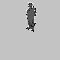

<PIL.Image.Image image mode=RGB size=60x60 at 0x7F43813D8668>
(60, 60)


In [ ]:
a=train[3]
mask = a['mask']
mask_t = mask
mask = mask_t.cpu()
# type(bgfg_cpu)

print("mask size is: ", mask.size())
from torchvision import transforms
im = transforms.ToPILImage()(mask).convert("RGB")
display(im)
print(im)
print(im.size)

BGFG Shape (224, 224)
mask size is:  torch.Size([1, 192, 192])


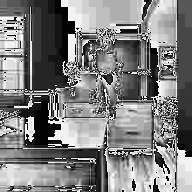

<PIL.Image.Image image mode=RGB size=192x192 at 0x7F43814EC400>
(192, 192)


In [ ]:
a=train[3]
mask = a['bgfg']
mask_t = mask
mask = mask_t.cpu()
# type(bgfg_cpu)

print("mask size is: ", mask.size())
from torchvision import transforms
im = transforms.ToPILImage()(mask).convert("RGB")
display(im)
print(im)
print(im.size)

BGFG Shape (224, 224)


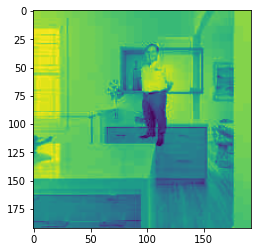

In [ ]:
import matplotlib.pyplot as plt


a=train[3]

bgfg= a['bgfg']
upd = bgfg.squeeze(0)
bgfg_np = upd/2+0.5
np_img = bgfg_np.numpy()

plt.imshow(np_img[:,:])

# print("bgfg size is: ", bgfg.size())
# from torchvision import transforms
# im = transforms.ToPILImage()(bgfg).convert("L")
# display(im)
# print(im)
# print(im.size)

In [ ]:
a=train[9]
bgfg= a['mask']

# bgfg = bgfg.cpu()
import matplotlib.pyplot as plt

plt.imshow(  bgfg.permute(1, 2, 0)  )

In [ ]:
a = np.ones((2,2))
b=np.expand_dims(a, 0)
b

In [ ]:
b.shape
# display_images(180,ax=plt) # some error axes don't match array

**DATASET & DATALOADERS**

In [12]:
import torch
import torchvision


class DataLoaders:
  def __init__(self, 
              batch_size=512,
              shuffle=True,
              num_workers=4,
              pin_memory=True,
              seed=1):
  
    """
    Arguments:-
    batch_size: Number of images to be passed in each batch
    shuffle(boolean):  If True, then shuffling of the dataset takes place
    num_workers(int): Number of processes that generate batches in parallel
    pin_memory(boolean):
    seed: Random Number, this is to maintain the consistency
    """
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')  # set device to cuda

    if use_cuda:
      torch.manual_seed(seed)
    
    self.dataLoader_args = dict(batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True ) if use_cuda else dict(batch_size=1, shuffle=True, num_workers = 1, pin_memory = True)


  def dataLoader(self, data):
    return torch.utils.data.DataLoader(data,**self.dataLoader_args)



def Data_To_Dataloader(trainset,testset,seed=1,batch_size=128,num_workers=4,pin_memory=True):
	"""
	Conv DataSet Obj to DataLoader
	"""

	SEED = 1

	# CUDA?
	cuda = torch.cuda.is_available()

	# For reproducibility
	torch.manual_seed(SEED)

	if cuda:
			torch.cuda.manual_seed(SEED)

	dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
	testloader = torch.utils.data.DataLoader(testset, **dataloader_args)


	return  trainloader, testloader

**TRAINLOADER & TESTLOADER**

In [13]:
trainLoader, testLoader = Data_To_Dataloader(train,test,batch_size=64)

**UNET IMPLEMENTATION**

In [14]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


# Double Conv
def double_conv(in_ch, out_ch, pad_value=0):
    conv = nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=pad_value),
                        nn.BatchNorm2d(out_ch),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=pad_value),
                        nn.BatchNorm2d(out_ch),
                        nn.ReLU(inplace=True))
    return conv


# Crop Image
def CropIt(input_tensor, target_tensor):
    # print('-'*40)
    # print('CROP FUNCTION DETAILS:')
    # print('target_tensor shape', target_tensor.shape)
    # print('input_tensor shape', input_tensor.shape)

    target_size = target_tensor.size()[2]
    # print('target size:-', target_size)
    input_size = input_tensor.size()[2]
    # print('input_size:-', input_size)
    
    delta = input_size - target_size # assuming input tensor to be greater than target_size
    # print('delta value before floor:-', delta)
    
    rev_delta = delta//2
    # print('delta value after floor:-', rev_delta)
    # if rev_delta % 2 !=0:
    #   rev_delta = rev_delta+1 
    # if input_size-(2*rev_delta) % 2 !=0:
    #   rev_delta += 1
    if input_size-(2*rev_delta) == target_size:
      # print('input tensor shape:', input_tensor.shape)

      return input_tensor[:,:, rev_delta:input_size-rev_delta, rev_delta:input_size-rev_delta]
    else:
      #   print('Updated rev_delta value', rev_delta)
      diff = (input_size - (2*rev_delta) - target_size)
      # print('diff', diff)
      # print('input tensor shape:',input_tensor.shape)
      return input_tensor[:,:, (rev_delta+diff):input_size-rev_delta, (rev_delta+diff):input_size-rev_delta]





class UNet(nn.Module):
    def __init__(self, in_c, out_c):
        super(UNet, self).__init__()

         
        # DownSampling Layer
        self.down_conv_1 = double_conv(in_c, 32, pad_value=1) 
        self.down_conv_2 = double_conv(32, 64, pad_value=1) 
        self.down_conv_3 = double_conv(64, 128, pad_value=1) 
        self.down_conv_4 = double_conv(128, 256) 
        self.down_conv_5 = double_conv(256, 512) 

        # MaxPool Layer
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)  

        # Upsampling Layer
        self.up_samp_1 = nn.ConvTranspose2d(in_channels=512,
                                            out_channels=256,
                                            kernel_size=2,
                                            stride=2)

        self.up_conv_1 = double_conv(512, 256 )


        self.up_samp_2 = nn.ConvTranspose2d(in_channels=256,
                                            out_channels=128,
                                            kernel_size=2,
                                            stride=2)

        self.up_conv_2 = double_conv(256, 128)


        self.up_samp_3 = nn.ConvTranspose2d(in_channels=128,
                                            out_channels=64,
                                            kernel_size=2,
                                            stride=2)

        self.up_conv_3 = double_conv(128, 64)


        self.up_samp_4 = nn.ConvTranspose2d(in_channels=64,
                                            out_channels=32,
                                            kernel_size=2,
                                            stride=2)

        self.up_conv_4 = double_conv(64, 32)   


        self.out = nn.Conv2d(in_channels=32,
                            out_channels=out_c,
                            kernel_size=1
        )    
      





    def forward(self, image):

#-------------------------------------------------------ENCODER---------------------------------------------------------#
        y1 = self.down_conv_1(image) # CCN
        # print('y1 shape:-', y1.shape)

        y2 = self.max_pool(y1)
        # print('y2 shape:-', y2.shape)

        y3 = self.down_conv_2(y2) # CCN
        # print('y3 shape:-', y3.shape)

        y4 = self.max_pool(y3)
        # print('y4 shape:-', y4.shape)

        y5 = self.down_conv_3(y4) # CCN
        # print('y5 shape:-', y5.shape)

        y6 = self.max_pool(y5)
        # print('y6 shape:-', y6.shape)

        y7 = self.down_conv_4(y6) # CCN
        # print('y7 shape:-', y7.shape)

        y8 = self.max_pool(y7)
        # print('y8 shape:-', y8.shape)

        y9 = self.down_conv_5(y8) 
        # print('y9 shape:-', y9.shape)
        # print('*'*40)

# import torch.nn.functional as nnf

# x = torch.rand(5, 1, 44, 44)
# out = nnf.interpolate(x, size=(224, 224), mode='bicubic', align_corners=False)




#-------------------------------------------------------DECODER---------------------------------------------------------#

# UP-SAMPLE 1        
        up_x1 = self.up_samp_1(y9)
        # print('Upsample x1.shape:-', up_x1.shape)
        # print('-'*40)

        crop_x1 = CropIt(y7, up_x1) # crop corresponding encoder part
        # print(' Crop x1.shape:-', crop_x1.shape)
        
        conc_x1 = self.up_conv_1(torch.cat([up_x1,crop_x1],1)) # concatenate the same
        # print('x,x1 concat shape:-', conc_x1.shape)

# UP-SAMPLE 2
        up_x2 = self.up_samp_2(conc_x1)
        # print('Upsample x2.shape', up_x2.shape)
        # print('-'*40)

        crop_x2 = CropIt(y5, up_x2)
        # print('Crop x2.shape:-', crop_x2.shape)

        # try: 
        conc_x2 = self.up_conv_2(torch.cat([up_x2, crop_x2],1))
        # print('x,x2 concat shape:-', conc_x2.shape)
        # except Exception as e:
          # print('Concatenation Error',e)

# UP-SAMPLE 3
        up_x3 = self.up_samp_3(up_x2)
        # print('Upsample x.shape', up_x3.shape)
        # print('-'*40)

        crop_x3 = CropIt(y3, up_x3)
        # print('Crop x3.shape:-', crop_x3.shape)
        
        # try: 
        conc_x3 = self.up_conv_3(torch.cat([up_x3, crop_x3],1))
        # print('x,x3 concat shape:-', conc_x3.shape)
        # except Exception as e:
          # print('Concatenation Error',e)
        # conc_x3 = self.up_conv_3(torch.cat([up_x3, crop_x3],1))
        # print('x,x3 concat shape:-', conc_x3.shape)

# UP-SAMPLE 4
        up_x4 = self.up_samp_4(up_x3)
        # print('Upsample x.shape', up_x4.shape)
        # print('-'*40)

        crop_x4 = CropIt(y1, up_x4)
        # print('Crop x3.shape:-', crop_x4.shape)

        # try: 
        conc_x4 = self.up_conv_4(torch.cat([up_x4,crop_x4],1))
        # print('x,x4 concat shape:-', conc_x4.shape)
        # except Exception as e:
          # print('Concatenation Error',e)
        
        # print('x,x3 concat shape:-', conc_x4.shape)
        

        # Final Layer
        x = self.out(conc_x4)

        return x

# img = torch.rand(1,1,572,572)
# model=UNet()
# print(model(img).shape)

In [15]:
from torchsummary import summary
import torch
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
unet_model = UNet(1,1).to(device)

summary(unet_model, input_size=(1, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 192]             320
       BatchNorm2d-2         [-1, 32, 192, 192]              64
              ReLU-3         [-1, 32, 192, 192]               0
            Conv2d-4         [-1, 32, 192, 192]           9,248
       BatchNorm2d-5         [-1, 32, 192, 192]              64
              ReLU-6         [-1, 32, 192, 192]               0
         MaxPool2d-7           [-1, 32, 96, 96]               0
            Conv2d-8           [-1, 64, 96, 96]          18,496
       BatchNorm2d-9           [-1, 64, 96, 96]             128
             ReLU-10           [-1, 64, 96, 96]               0
           Conv2d-11           [-1, 64, 96, 96]          36,928
      BatchNorm2d-12           [-1, 64, 96, 96]             128
             ReLU-13           [-1, 64, 96, 96]               0
        MaxPool2d-14           [-1, 64,

**Tensorboard Setup**

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/ImageSegmentation-UNET')

In [ ]:
writer.add_graph(model, img_seg)
writer.close()

**Jaccard Score**

In [16]:
def f_score(prediction, ground_truth, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """
    if activation is None:
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    prediction = activation_fn(prediction)

    if threshold is not None:
        prediction = (prediction > threshold).float()


    tp = torch.sum(ground_truth * prediction) # TRUE POSITIVE
    fp = torch.sum(prediction) - tp  # FALSE POSITIVE
    fn = torch.sum(ground_truth) - tp  # FALSE NEGATIVE

    jaccard_score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return jaccard_score




**DICE LOSS**

In [19]:

class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
  
    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)


In [18]:
def dice_no_threshold(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
    #activation: str = "Sigmoid"
):

    #activation_fn = get_activation_fn(activation)
    #outputs = activation_fn(outputs)
    outputs = torch.sigmoid(outputs)

    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice

**TRAIN & TEST MODEL**

In [51]:
import torch
import torchvision
from tqdm import notebook
import torch.nn.functional as F
from time import time

In [52]:
unet_model = UNet(1,1).to(device)


In [34]:
# CRITERION PART
mask_criterion = BCEDiceLoss(activation='softmax2d')
optimizer = optim.Adam(unet_model.parameters(), lr = 0.001)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=2, cooldown=2)

In [77]:
len(testLoader)

24

In [35]:
epochs = 30
train_losses, valid_losses, dice_scores, lr_rates= [], [], [], []
_samples = [] # to collect tensor images
valid_loss_min = np.inf # to compare validation loss

for epoch in range(epochs+1):
  print('EPOCH:', epoch)
  train_loss, valid_loss, dice_score = 0.0, 0.0, 0.0 # initializing batch params
  
  # MODEL TRAINING
  unet_model.train() 
  pbar = notebook.tqdm(enumerate(trainLoader))

  for batch_idx, data in enumerate(pbar):
    bgfg, mask = data[1]['bgfg'].to(device), data[1]['mask'].to(device) 

    # print('bgfg shape', bgfg.size())
    # print('mask shape', mask.size())


    # clear the gradients of all optimized variables
    optimizer.zero_grad()

    # Run the model on this input batch
    pred_mask = unet_model(bgfg)

    # calculate loss
    loss = mask_criterion(pred_mask, mask) # Output, Target

    # for backpropagation
    loss.backward()

    # parameter update
    optimizer.step()

    # calculate average training loss
    train_data_size = len(trainLoader)*trainLoader.batch_size
    train_loss += loss.item()*trainLoader.batch_size

    # Update PBAR-TQDM
    pbar.set_description(f'Train Loss={loss.item():0.3f}')

    # _train_loss += loss.item()*1 # this 'data.size(0)' I haven't figured out
    
  # append train loss and update the same
  train_loss = train_loss/train_data_size
  train_losses.append(train_loss)
  



  # MODEL VALIDATION
  unet_model.eval()
  pbar = notebook.tqdm(enumerate(testLoader))
  validation = 0 

  with torch.no_grad():
    for batch_idx, data in enumerate(pbar):
      bgfg, mask = data[1]['bgfg'].to(device), data[1]['mask'].to(device)

      # Model Predictions
      pred_mask = unet_model(bgfg)

      # calculate loss
      loss = mask_criterion(pred_mask, mask)

      # Update PBAR-TQDM
      pbar.set_description(f'Test Loss={loss.item():0.3f}')

      # calculate average test loss
      test_data_size = len(testLoader)*testLoader.batch_size
      valid_loss += loss.item()*testLoader.batch_size

      # For checking prediction results
      if batch_idx == len(testLoader)-1:
        for i in range(len(testLoader)):
          _samples.append({'pred_mask': pred_mask[i] ,'mask': mask[i], 'bgfg': bgfg[i]})

      # update learning rate
      scheduler.step(valid_loss)

      # current lr
      clr = [param_group['lr'] for param_group in optimizer.param_groups][-1]

    # append test loss
    valid_loss = valid_loss/test_data_size
    valid_losses.append(valid_loss_min)
    


 # print training/validation statistics 
  print('Training Loss: {:.4f}  Validation Loss: {:.4f} '.format( train_loss, valid_loss))
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
      torch.save(unet_model.state_dict(), '/content/drive/My Drive/Saved S15 Models/image_segmentation.pt')
      valid_loss_min = valid_loss

EPOCH: 0



Training Loss: 0.9277  Validation Loss: 1.3445 
Validation loss decreased (inf --> 1.344491).  Saving model ...
EPOCH: 1



Training Loss: 0.7857  Validation Loss: 1.3529 
EPOCH: 2



Training Loss: 0.7846  Validation Loss: 1.3518 
EPOCH: 3



Training Loss: 0.7843  Validation Loss: 1.3522 
EPOCH: 4



Training Loss: 0.7845  Validation Loss: 1.3502 
EPOCH: 5



Training Loss: 0.7846  Validation Loss: 1.3522 
EPOCH: 6



Training Loss: 0.7846  Validation Loss: 1.3520 
EPOCH: 7



Training Loss: 0.7844  Validation Loss: 1.3502 
EPOCH: 8



Training Loss: 0.7839  Validation Loss: 1.3514 
EPOCH: 9



Training Loss: 0.7844  Validation Loss: 1.3520 
EPOCH: 10



Training Loss: 0.7844  Validation Loss: 1.3516 
EPOCH: 11



Training Loss: 0.7844  Validation Loss: 1.3487 
EPOCH: 12



Training Loss: 0.7844  Validation Loss: 1.3500 
EPOCH: 13



Training Loss: 0.7843  Validation Loss: 1.3518 
EPOCH: 14



Training Loss: 0.7846  Validation Loss: 1.3538 
EPOCH: 15


KeyboardInterrupt: ignored

In [106]:
import gc
gc.collect()

604

In [107]:
torch.cuda.empty_cache()

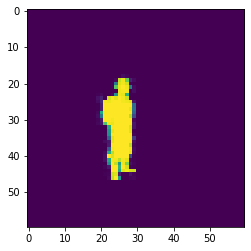

In [42]:
import matplotlib.pyplot as plt
a = _samples[1]
mask_image = a['mask']
# pred_mask = a['pred_mask']
upd = mask_image.squeeze(0).cpu()
upd_np = upd.numpy()
plt.imshow(upd_np[:,:])

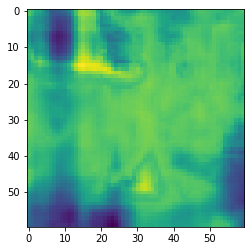

In [43]:
import matplotlib.pyplot as plt
a = _samples[1]
mask_image = a['mask']
pred_mask = a['pred_mask']
upd = pred_mask.squeeze(0).cpu()
upd_np = upd.numpy()+0.6
plt.imshow(upd_np[:,:])

In [ ]:
import matplotlib.pyplot as plt

img = a['pred_mask']
# img.size()
upd = img.squeeze(0).cpu()
upd.size()

bgfg_np = upd
# bgfg_np
np_img = bgfg_np.numpy()
# type(np_img)
plt.imshow(np_img[:,:])

# print("bgfg size is: ", bgfg.size())
# from torchvision import transforms
# im = transforms.ToPILImage()(bgfg).convert("L")
# display(im)
# print(im)
# print(im.size)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()

network = UNet(1,1)
images = enumerate(trainLoader)


input, target = images[1]
# print(labels)
# grid = torchvision.utils.make_grid(images)

# tb.add_image('images', grid)
# tb.add_graph(network, images)
# tb.close()

TypeError: ignored

**UNET Testing**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')  # set device to cuda

_samples = [] # to extract predictions

unet_model = UNet(1,1).to(device)
optimizer = optim.SGD(unet_model.parameters(),lr=0.001)
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)
mask_criterion = DiceLoss()


unet = EvaluateModel(unet_model, trainLoader, device, testLoader, mask_criterion, optimizer, scheduler )
unet.train_test(epochs=30)

EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Train set: Average loss: 1.0928, Coef: (-0.09281)

Test Set: Average loss: 1.0795, Coef: (-0.07953)

lr 0.001
EPOCH: 2



Train set: Average loss: 1.1012, Coef: (-0.10124)

Test Set: Average loss: 1.0887, Coef: (-0.08870)

lr 0.001
EPOCH: 3



Train set: Average loss: 1.0960, Coef: (-0.09597)

Test Set: Average loss: 1.0951, Coef: (-0.09515)

lr 0.001
EPOCH: 4



Train set: Average loss: 1.0380, Coef: (-0.03803)

Test Set: Average loss: 1.1077, Coef: (-0.10771)

lr 0.001
EPOCH: 5



Train set: Average loss: 1.0668, Coef: (-0.06676)

Test Set: Average loss: 1.1392, Coef: (-0.13919)

lr 0.001
EPOCH: 6



Train set: Average loss: 1.0547, Coef: (-0.05469)

Test Set: Average loss: 1.1210, Coef: (-0.12102)

lr 0.001
EPOCH: 7



Train set: Average loss: 1.1024, Coef: (-0.10235)

Test Set: Average loss: 1.1101, Coef: (-0.11011)

lr 0.001
EPOCH: 8



Train set: Average loss: 1.0570, Coef: (-0.05701)

Test Set: Average loss: 1.1021, Coef: (-0.10208)

lr 0.001
EPOCH: 9



Train set: Average loss: 1.0111, Coef: (-0.01111)

Test Set: Average loss: 1.0729, Coef: (-0.07289)

lr 0.001
EPOCH: 10



Train set: Average loss: 1.0092, Coef: (-0.00918)

Test Set: Average loss: 1.1165, Coef: (-0.11653)

lr 0.001
EPOCH: 11



Train set: Average loss: 1.0803, Coef: (-0.08032)

Test Set: Average loss: 1.0905, Coef: (-0.09051)

lr 0.001
EPOCH: 12



Train set: Average loss: 1.0263, Coef: (-0.02627)

Test Set: Average loss: 1.1574, Coef: (-0.15739)

lr 0.001
EPOCH: 13



Train set: Average loss: 1.0051, Coef: (-0.00509)

Test Set: Average loss: 1.0715, Coef: (-0.07154)

lr 0.001
EPOCH: 14



Train set: Average loss: 1.1229, Coef: (-0.12291)

Test Set: Average loss: 1.1371, Coef: (-0.13706)

lr 0.001
EPOCH: 15



Train set: Average loss: 1.0448, Coef: (-0.04478)

Test Set: Average loss: 1.0481, Coef: (-0.04814)

lr 0.001
EPOCH: 16



Train set: Average loss: 0.9927, Coef: (0.00727)

Test Set: Average loss: 1.1339, Coef: (-0.13390)

lr 0.001
EPOCH: 17



Train set: Average loss: 0.9600, Coef: (0.04003)

Test Set: Average loss: 1.1368, Coef: (-0.13684)

lr 0.001
EPOCH: 18



Train set: Average loss: 0.9996, Coef: (0.00036)

Test Set: Average loss: 1.0584, Coef: (-0.05838)

lr 0.001
EPOCH: 19



Train set: Average loss: 1.0086, Coef: (-0.00856)

Test Set: Average loss: 1.0974, Coef: (-0.09743)

lr 0.001
EPOCH: 20



Train set: Average loss: 0.9557, Coef: (0.04434)

Test Set: Average loss: 1.0517, Coef: (-0.05175)

lr 0.001
EPOCH: 21



Train set: Average loss: 0.9692, Coef: (0.03080)

Test Set: Average loss: 1.1181, Coef: (-0.11814)

lr 0.001
EPOCH: 22



Train set: Average loss: 1.0269, Coef: (-0.02693)

Test Set: Average loss: 1.0048, Coef: (-0.00479)

lr 0.001
EPOCH: 23



Train set: Average loss: 0.9793, Coef: (0.02073)

Test Set: Average loss: 1.1414, Coef: (-0.14136)

lr 0.001
EPOCH: 24



Train set: Average loss: 1.0066, Coef: (-0.00663)

Test Set: Average loss: 1.1064, Coef: (-0.10637)

lr 0.001
EPOCH: 25



Train set: Average loss: 0.9495, Coef: (0.05055)

Test Set: Average loss: 1.0949, Coef: (-0.09488)

lr 0.001
EPOCH: 26



Train set: Average loss: 0.9343, Coef: (0.06573)

Test Set: Average loss: 1.1286, Coef: (-0.12865)

lr 0.001
EPOCH: 27



Train set: Average loss: 0.9813, Coef: (0.01870)

Test Set: Average loss: 1.0978, Coef: (-0.09784)

lr 0.001
EPOCH: 28



Train set: Average loss: 0.9801, Coef: (0.01992)

Test Set: Average loss: 1.1239, Coef: (-0.12386)

lr 0.001
EPOCH: 29



Train set: Average loss: 0.9550, Coef: (0.04500)

Test Set: Average loss: 1.0499, Coef: (-0.04990)

lr 0.001
EPOCH: 30



Train set: Average loss: 1.0069, Coef: (-0.00693)

Test Set: Average loss: 1.1033, Coef: (-0.10332)

lr 0.001



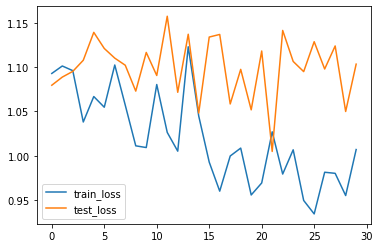

In [ ]:
import matplotlib.pyplot as plt # lr 0.0001
plt.plot(unet.train.train_losses, label='train_loss')
plt.plot( unet.test.test_losses, label='test_loss')
plt.legend()

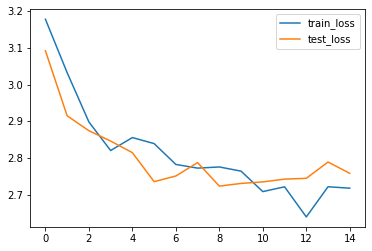

In [ ]:
import matplotlib.pyplot as plt # this is for lr 0.001
plt.plot(unet.train.train_losses, label='train_loss')
plt.plot( unet.test.test_losses, label='test_loss')
plt.legend()

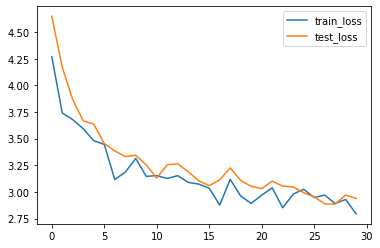

In [ ]:
import matplotlib.pyplot as plt # this is for lr 0.0001
plt.plot(unet.train.train_losses, label='train_loss')
plt.plot( unet.test.test_losses, label='test_loss')
plt.legend()

In [ ]:
train_a=train[1]
train_a


{'bgfg': tensor([[[ 1.4185,  1.4185,  1.4185,  ...,  1.3519,  1.3519,  1.3519],
          [ 1.4185,  1.4185,  1.4185,  ...,  1.3519,  1.3519,  1.3519],
          [ 1.4185,  1.4185,  1.4185,  ...,  1.3519,  1.3519,  1.3519],
          ...,
          [-0.2800, -0.2800, -0.2800,  ...,  0.8190,  0.8190,  0.8190],
          [-0.2800, -0.2800, -0.2800,  ...,  0.8190,  0.8190,  0.8190],
          [-0.3466, -0.3466, -0.3466,  ...,  0.8190,  0.8190,  0.8190]]]),
 'mask': tensor([[[-0.2401, -0.2401, -0.2401,  ..., -0.2401, -0.2401, -0.2401],
          [-0.2401, -0.2401, -0.2401,  ..., -0.2401, -0.2401, -0.2401],
          [-0.2401, -0.2401, -0.2401,  ..., -0.2401, -0.2401, -0.2401],
          ...,
          [-0.2401, -0.2401, -0.2401,  ..., -0.2401, -0.2401, -0.2401],
          [-0.2401, -0.2401, -0.2401,  ..., -0.2401, -0.2401, -0.2401],
          [-0.2401, -0.2401, -0.2401,  ..., -0.2401, -0.2401, -0.2401]]])}

In [ ]:
a=_samples[1]
a

{'bgfg': tensor([[[ 0.2862,  0.3028,  0.3195,  ..., -1.5789, -1.5789, -1.5789],
          [ 0.3028,  0.3028,  0.3361,  ..., -1.5789, -1.5789, -1.5789],
          [ 0.3195,  0.3361,  0.3528,  ..., -1.5789, -1.5789, -1.5789],
          ...,
          [ 0.9523,  0.9523,  0.9523,  ..., -0.1135,  0.0197,  0.1363],
          [ 0.9523,  0.9523,  0.9523,  ..., -0.1634, -0.1301, -0.0968],
          [ 0.9523,  0.9523,  0.9523,  ..., -0.2300, -0.2967, -0.3300]]],
        device='cuda:0'),
 'pred_mask': tensor([[[-0.2678, -0.2359, -0.2463,  ..., -0.3555, -0.3768, -0.4775],
          [-0.1887, -0.2757, -0.2623,  ..., -0.4430, -0.3604, -0.3587],
          [-0.2284, -0.2612, -0.2225,  ..., -0.3700, -0.3379, -0.3152],
          ...,
          [-0.2733, -0.2581, -0.2217,  ..., -0.1412, -0.2597, -0.1295],
          [-0.2779, -0.2339, -0.1674,  ..., -0.1671, -0.3531, -0.2356],
          [-0.2961, -0.2215, -0.1733,  ..., -0.3494, -0.5629, -0.4949]]],
        device='cuda:0')}

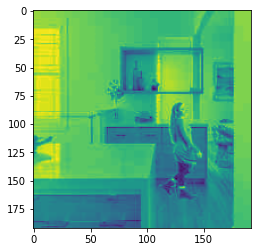

In [ ]:
bgfg= train_a['bgfg']

upd = bgfg.squeeze(0)
# upd.size()
bgfg_np = upd/2
# bgfg_np
np_img = bgfg_np.cpu().numpy()
type(np_img)
plt.imshow(np_img)

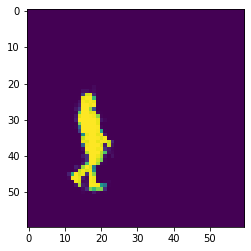

In [ ]:
bgfg= train_a['mask']

upd = bgfg.squeeze(0)
# upd.size()
bgfg_np = upd/2

# bgfg_np
np_img = bgfg_np.cpu().numpy()
# type(np_img)
plt.imshow(np_img)

In [ ]:
np_img.shape

(60, 60)

In [ ]:
from PIL import Image
pil_img = Image.fromarray(np_img, mode='L')
pil_img.save('n.png')

mask size is:  torch.Size([1, 60, 60])


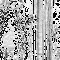

<PIL.Image.Image image mode=L size=60x60 at 0x7FCE583A5240>
(60, 60)


In [ ]:
mask_t = _samples[1]['pred_mask']
mask = mask_t.cpu()
# type(bgfg_cpu)

print("mask size is: ", mask.size())
from torchvision import transforms
im = transforms.ToPILImage()(mask)#.convert("RGB")
display(im)
print(im)
print(im.size)

In [ ]:
a=train[9]
bgfg=  _samples[1]['mask']
# type(bgfg)
a=bgfg.squeeze(0).cpu()
anp = a.numpy()
# type(anp)
img = Image.fromarray(anp, 'L')
img.save('out.png')

# import matplotlib.pyplot as plt
# plt.imshow(  a.permute(0,1)  )

BGFG Shape (224, 224)


IndexError: ignored

In [ ]:
img = Image.fromarray(a, 'RGB')
img.save('out.png')

AttributeError: ignored

**SAVING & LOADING MODEL**

In [ ]:
path = ''

# SAVE
torch.save(unet_model, path)

# LOAD
model=torch.load(path)

**TENSORBOARD INTEGRATION**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter 

print(torch.__version__)
print(torchvision.__version__)


class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  def forward(self, t):
    t = F.relu(self.conv1(t))
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    t = F.relu(self.conv2(t))
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    t = t.flatten(start_dim=1)
    t = F.relu(self.fc1(t))
    t = F.relu(self.fc2(t))
    t = self.out(t)

    return t


1.5.1+cu101
0.6.1+cu101


In [ ]:
train_set = torchvision.datasets.FashionMNIST(
  root='./data',
  train=True,
  download=True,
  transform=transforms.Compose([
    transforms.ToTensor()
  ])
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)


In [ ]:
 # Tensorboard Setting
 tb = SummaryWriter() # creating an object of summary writer
 network = Network()
 images, labels = next(iter(train_loader))
 grid = torchvision.utils.make_grid(images)
 

In [ ]:
# add objects
# tb.add_images('images',grid)
tb.add_graph(network, images)
tb.close()

In [ ]:
# python tensorboard_demo.py
from tensorflow import summary
%load_ext tensorboard
%tensorboard --logdir /content/runs

**TENSORBOARD COLAB**

In [ ]:
! pip install tensorboardcolab

In [ ]:
from tensorboardcolab import TensorBoardColab
tb = TensorBoardColab()


**SETTING MODEL CONFIGS**

In [ ]:
class ModelConfig:
  def __init__(self, **kwargs):
    for k, v in kwargs:
      setattr(self, k, v)



model_config = Config(
    cuda = True if torch.cuda.is_available() else False,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    seed = 9091,
    lr = 0.01,
    epochs = 4,
    save_model = False,
    batch_size = 32,
    log_interval = 100
)

2

In [ ]:
import torch
import torchvision
from tqdm import notebook
import torch.nn.functional as F


class TrainModel:
    def __init__(self, model, device, trainloader, optimizer, scheduler, mask_criterion):
        self.model = model
        self.device = device
        self.trainloader = trainloader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.mask_criterion = mask_criterion

        # initialize training variables
        self.train_losses = []
        self.train_acc = []
        self.learning_rate = []

        # pass time
        self.pass_time = []

        # TensorboardColab
        self.tb = TensorboardColab()
        self.train_iter = 0
        self.test_iter = 0

    def train(self):
        self.model.train()
        pbar = notebook.tqdm(enumerate(self.trainloader))
        mask_coeff=0
        start = time()
        for batch_idx, data in pbar:

          self.train_iter += 1
          bgfg, mask_target = data['bgfg'].to(self.device), data['mask'].to(self.device)
          
          # set optimzer to zero grad
          self.optimizer.zero_grad()
          
          # get the predictions
          pred_mask = self.model(bgfg)


          # calculate DICE LOSS
          mask_loss = self.mask_criterion(pred_mask, mask_target) 
          loss = mask_loss
          mask_coeff += dice_coefficient(pred_mask,mask_target, mask = True).item() # Segmentation Metric

          # BackProp
          loss.backward()
          self.optimizer.step()
          
          # Batch LR
          _lr = self.optimizer.param_groups[0]['lr']
          

          # Update PBAR-TQDM
          pbar.set_description(f'Loss={loss:0.3f}')
          end = time()
          total_time = end-start


          # if self.scheduler and isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
          #     self.scheduler.step(loss)

          
        print('Train set: Average loss: {:.4f}, Coef: ({:.5f})\n'.format((mask_loss),  (mask_coeff) /len(self.trainloader)))
        print('Train Set: Accuracy: {:.3f}'.format(mask_coeff/len(self.trainloader)))
        self.pass_time.append(total_time)
        self.train_losses.append((mask_loss))
        self.train_acc.append( mask_coeff/len(self.trainloader))
        self.learning_rate.append(_lr)
        
        # writing model attr to tensorboard
        self.tb.save_value('Train Accuracy', 'train acc', self.train_iter, mask_coeff/len(self.trainloader))
        self.tb.save_value('Train Loss', 'train loss', self.train_iter, mask_loss) 
        


class TestModel:
    def __init__(self, model, device, testloader, mask_criterion, scheduler):
      self.model = model
      self.device = device
      self.testloader = testloader
      self.mask_criterion = mask_criterion
      self.scheduler = scheduler
      self.test_losses = []
      self.test_acc = []
      # self.learning_rate = []
      

    def test(self):
        self.model.eval()
        mask_coeff=0
        with torch.no_grad():
          for batch_idx, data in enumerate(self.testloader):

            self.test_iter += 1
            bgfg, mask_target = data['bgfg'].to(self.device), data['mask'].to(self.device)          
            # Mask Predictions
            pred_mask = self.model(bgfg)
            # print('pred_mask type test', type(pred_mask))
            

            # Calculate DICE LOSS
            mask_loss = self.mask_criterion(pred_mask, mask_target) 
            loss = mask_loss
            mask_coeff += dice_coefficient(pred_mask,mask_target, mask = True).item() # Segmentation Metric
        
            # if self.scheduler and isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            #     self.scheduler.step(loss)

            if batch_idx < 1:
              for i in range(self.testloader.batch_size):
                _samples.append({'pred_mask': pred_mask[i] ,'bgfg': bgfg[i]})


              
          print('Test Set: Average loss: {:.4f}, Coef: ({:.5f})\n'.format((mask_loss),  (mask_coeff) /len(self.testloader)))
          print('Test Set: Accuracy: {:.3f}'.format(mask_coeff/len(self.testloader)))
          self.test_losses.append((mask_loss))
          self.test_acc.append( mask_coeff/len(self.testloader))

          # writing test stats to tensorboard
          self.tb.save_value('Test Accuracy', 'test acc', self.test_iter, mask_coeff/len(self.testloader))
          self.tb.save_value('Test Loss', 'test loss', self.test_iter, mask_loss) 
          

class EvaluateModel:
    def __init__(self, model, trainloader, device, testloader, mask_criterion, optimizer, scheduler):
        self.model = model
        self.trainloader = trainloader
        self.testloader = testloader
        self.mask_criterion = mask_criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

        self.train = TrainModel(self.model, self.device, self.trainloader, self.optimizer, self.scheduler, self.mask_criterion)
        self.test = TestModel(self.model, self.device,self.testloader, self.mask_criterion, self.scheduler)

    
    def train_test(self, epochs=10):
        pbar = notebook.tqdm(range(1, epochs+1), desc="Epochs")
        for epoch in pbar:
            # gc.collect()
            self.train.train()
            self.test.test()
            lr = self.optimizer.param_groups[0]['lr']     
            print('lr', lr)    
            if self.scheduler and not isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                self.scheduler.step()
            # pbar.write(f"Learning Rate = {lr:0.6f}")


**Optimized Way of OOP**

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import SGD


class ModelConfig:
  def __init__(self, **kwargs):
    for k, v in kwargs:
      setattr(self, k, v)

unet_model = UNet(3,3).to(device)

model_config = Config(
    cuda = True if torch.cuda.is_available() else False,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    seed = 9091,
    model = unet_model, 
    trainloader = trainLoader,
    testloader = testLoader, 
    lr = 0.01,
    mask_criterion = DiceLoss(),
    optimizer = SGD(unet_model.parameters(),lr=0.01),
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True),
    epochs = 10,
    save_model = False,
    batch_size = 128,
   
)

In [ ]:
import torch
import torchvision
from tqdm import notebook
import torch.nn.functional as F


class Trainer:
  def __init__(self, config):
    self.model = config.model
    self.device = config.device
    self.trainloader = config.trainloader
    self.epochs = config.epochs
    self.optimizer = config.optimizer
    self.scheduler = config.scheduler
    self.mask_criterion = config.mask_criterion

    # initialize training variables
    self.train_losses = []
    self.train_acc = []
    self.test_losses = []
    self.test_acc = []
    self.learning_rate = []

    # pass time
    self.pass_time = []

    # TensorboardColab
    self.tb = TensorboardColab()
    self.train_iter = 0
    self.test_iter = 0


  def train(self):
    self.model.train()
    pbar = notebook.tqdm(enumerate(self.trainloader))
    mask_coeff=0
    start = time()

    for batch_idx, data in pbar:
      self.train_iter += 1
      bgfg, mask_target = data['bgfg'].to(self.device), data['mask'].to(self.device)
      
      # set optimzer to zero grad
      self.optimizer.zero_grad()
      
      # get the predictions
      pred_mask = self.model(bgfg)

      # calculate DICE LOSS
      mask_loss = self.mask_criterion(pred_mask, mask_target) 
      loss = mask_loss
      mask_coeff += dice_coefficient(pred_mask,mask_target, mask = True).item() # Segmentation Metric

      # BackProp
      loss.backward()
      self.optimizer.step()
      
      # Batch LR
      _lr = self.optimizer.param_groups[0]['lr']
      
      # Update PBAR-TQDM
      pbar.set_description(f'Loss={loss:0.3f}')
      end = time()
      total_time = end-start
      
    print('Train set: Average loss: {:.4f}, Coef: ({:.5f})\n'.format((mask_loss),  (mask_coeff) /len(self.trainloader)))
    print('Train Set: Accuracy: {:.3f}'.format(mask_coeff/len(self.trainloader)))
    self.pass_time.append(total_time)
    self.train_losses.append((mask_loss))
    self.train_acc.append( mask_coeff/len(self.trainloader))
    self.learning_rate.append(_lr)
    
    # writing model attr to tensorboard
    self.tb.save_value('Train Accuracy', 'train acc', self.train_iter, mask_coeff/len(self.trainloader))
    self.tb.save_value('Train Loss', 'train loss', self.train_iter, mask_loss) 
    

  def test(self):
    self.model.eval()
    mask_coeff=0

    with torch.no_grad():
      for batch_idx, data in enumerate(self.testloader):
        self.test_iter += 1
        bgfg, mask_target = data['bgfg'].to(self.device), data['mask'].to(self.device)    

        # Mask Predictions
        pred_mask = self.model(bgfg)
        # print('pred_mask type test', type(pred_mask))
        
        # Calculate DICE LOSS
        mask_loss = self.mask_criterion(pred_mask, mask_target) 
        loss = mask_loss
        mask_coeff += dice_coefficient(pred_mask,mask_target, mask = True).item() # Segmentation Metric
  
        if batch_idx < 1:
          for i in range(self.testloader.batch_size):
            _samples.append({'pred_mask': pred_mask[i] ,'bgfg': bgfg[i]})
            
      print('Test Set: Average loss: {:.4f}, Coef: ({:.5f})'.format((mask_loss),  (mask_coeff) /len(self.testloader)))
      print('Test Set: Accuracy: {:.3f}'.format(mask_coeff/len(self.testloader)))
      self.test_losses.append((mask_loss))
      self.test_acc.append( mask_coeff/len(self.testloader))

      # writing test stats to tensorboard
      self.tb.save_value('Test Accuracy', 'test acc', self.test_iter, mask_coeff/len(self.testloader))
      self.tb.save_value('Test Loss', 'test loss', self.test_iter, mask_loss) 
      

def evaluate(configs):
  
  t1 = Trainer(configs)
  for epoch in range(t1.epoch+1):
    t1.train()
    t1.test()
    if t1.scheduler and isinstance(t1.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
      t1.scheduler.step(t1.test_losses[-1])
    t1.flush_line()

  if t1.save_model:
      torch.save(t1.model.state_dict(),"UNET_ImageSegmentation.pt")

